In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

def KL_Xq(X, q, k=10): 
    ''' X is a matrix, k is float, q is a function 
    '''
    try: 
        n, d = X.shape
    except ValueError: 
        n, d = X.reshape(-1,1).shape

    p_Xi = hat_p(X, k=k)
    q_Xi = q(X)
    return np.sum(np.log(p_Xi) - np.log(q_Xi))/n

In [4]:
def KL_XY_SKL(X, m, k, div_func='kl', n_sample=10, Cov=None): 
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(NG.kNNdiv_gauss(X, None, Knn=k, div_func=div_func, gauss=Y))
    return np.average(_kl), np.std(_kl)

In [22]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

C_x_p = np.zeros(C_x.shape)
for i in range(C_x.shape[0]): 
    for j in range(C_x.shape[1]): 
        if i != j: 
            C_x_p[i,j] = 1.1 * C_x[i,j]
            
C_x_pp = np.zeros(C_x.shape)
for i in range(C_x.shape[0]): 
    for j in range(C_x.shape[1]): 
        if i != j: 
            C_x_pp[i,j] = 0.9 * C_x[i,j]

37 dimensional data with 2048 samples


In [23]:
def Xsample(n): 
    return mvn(np.zeros(dim), C_x, size=n)

def Xpsample(n): 
    return mvn(np.zeros(dim), C_x_p, size=n)

def Xppsample(n): 
    return mvn(np.zeros(dim), C_x_pp, size=n)

In [24]:
ns = [1000, 2000, 3000, 5000, 8000]
X_ref_ns, Xp_ref_ns, Xpp_ref_ns = [], [], [] 
for n in ns: 
    X_ref_ns.append(Xsample(n))
    Xp_ref_ns.append(Xpsample(n))
    Xpp_ref_ns.append(Xppsample(n))

In [26]:
KL_XY_ns, KL_XpY_ns, KL_XppY_ns, sigKL_XY_ns, sigKL_XpY_ns, sigKL_XppY_ns = [], [], [], [], [], [] 
for i in range(len(ns)): 
    avgKLxy, sigKLxy = KL_XY_SKL(X_ref_ns[i], ns[i], 2, Cov=C_x)
    KL_XY_ns.append(avgKLxy)
    sigKL_XY_ns.append(sigKLxy)
    
    avgKLxpy, sigKLxpy = KL_XY_SKL(Xp_ref_ns[i], ns[i], 2, Cov=C_x)
    KL_XpY_ns.append(avgKLxpy)
    sigKL_XpY_ns.append(sigKLxpy)
    
    avgKLxppy, sigKLxppy = KL_XY_SKL(Xpp_ref_ns[i], ns[i], 2, Cov=C_x)
    KL_XppY_ns.append(avgKLxppy)
    sigKL_XppY_ns.append(sigKLxppy)

Text(0,0.5,'KL Divergence')

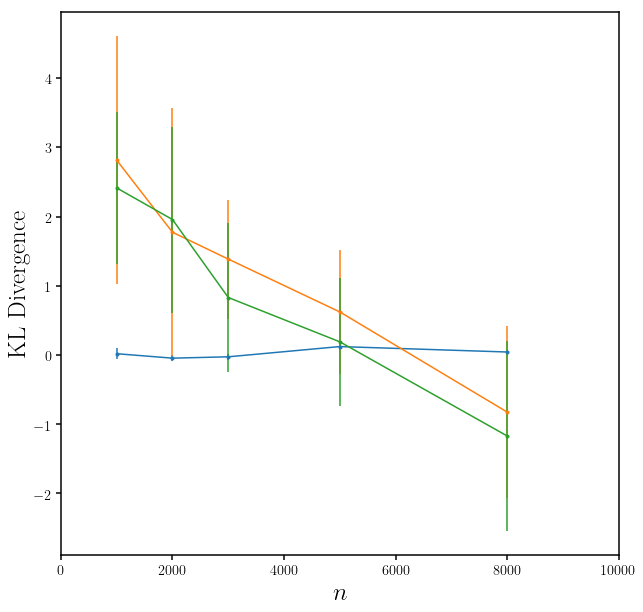

In [28]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.errorbar(ns, KL_XY_ns, yerr=sigKL_XY_ns, fmt='.C0')
sub.plot(ns, KL_XY_ns, c='C0')

sub.errorbar(ns, np.array(KL_XpY_ns)-305, yerr=sigKL_XpY_ns, fmt='.C1')
sub.plot(ns, np.array(KL_XpY_ns)-305, c='C1')

sub.errorbar(ns, np.array(KL_XppY_ns)-305, yerr=sigKL_XppY_ns, fmt='.C2')
sub.plot(ns, np.array(KL_XppY_ns)-305, c='C2')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([0, 10000])
sub.set_ylabel('KL Divergence', fontsize=25)